# Task 1: Big Cats
### Alina, Lisa, Ömer and Nikolai

### Setup

In [25]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os

from PIL import Image
from os import listdir
from os.path import isfile, join
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

### Data visualisation
Visualise one data sample per class

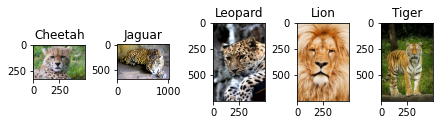

In [26]:
dataset_path = '../Data-PR-As2/BigCats/'
class_names = [dir for dir in os.listdir(dataset_path) if os.path.isdir(join(dataset_path + dir))]

fig, axs = plt.subplots(1,len(class_names), constrained_layout=True)
fig.patch.set_facecolor('white')
axs = axs.flatten()
for class_ in class_names:
    files = [f for f in listdir(dataset_path + class_) if isfile(join(dataset_path + class_, f))]
    img_plot_path = dataset_path + class_ + '/' + files[0]
    with Image.open(img_plot_path) as img:
        axs[class_names.index(class_)].imshow(img)
    axs[class_names.index(class_)].title.set_text(class_)
plt.show()

### Feature extraction

In [27]:
img_labels = []
features = []
sift = cv.SIFT_create()
for class_ in class_names:
    files = [f for f in listdir(dataset_path + class_) if isfile(join(dataset_path + class_, f))]
    for file in files:
        img = cv.imread(dataset_path + class_ + '/' + file)
        _, des = sift.detectAndCompute(img, None)
        features.append(des[np.random.choice(des.shape[0], 247)]) # minimum
        img_labels.append(class_)

In [28]:
def build_histogram(kmeans, data):
    pred = kmeans.predict(data.astype(float))
    hist, _ = np.histogram(pred, bins=300)
    hist_norm = [float(i)/sum(hist) for i in hist]
    return hist

# Reflects importance of BOVW features in the image histograms
# See https://en.wikipedia.org/wiki/Tf%E2%80%93idf for more information
def tf_idf_histogram(train_hists, test_hists):
    hists = np.concatenate((np.array(train_hists), np.array(test_hists)), axis=0)
    tf_idf_hists = np.zeros(hists.shape)
    N = hists.shape[0] # total number of images
    n_i = np.sum(hists > 0, axis=0) # number of images where the word w appears (per word)
    for hist_id in range(N):
        n_words_i = np.sum(hists[hist_id]) # number of words in the image
        for word_id in range(len(hists[hist_id])):
            n_wi = hists[hist_id, word_id] # count of word w in image i
            tf_idf_hists[hist_id, word_id] = n_wi / n_words_i * np.log(N/n_i[word_id])
    return tf_idf_hists[:len(train_hists)], tf_idf_hists[-len(test_hists):]

def run_model(model, train_data, train_labels, test_data, test_labels):
    model.fit(train_data, train_labels)
    yhat = model.predict(test_data)
    accuracy = accuracy_score(test_labels, yhat)
    # f_1 = f1_score(test_labels, yhat)
    # conf_mat = confusion_matrix(test_labels, yhat)
    # roc_auc = roc_auc_score(test_labels, yhat)
    # return [accuracy, f_1, conf_mat, roc_auc], model
    return [accuracy, 0, 0, 0], model

Cluster descriptors

In [29]:
img_train, img_test, label_train, label_test = train_test_split(features, img_labels, test_size=0.2)
x_train = []
y_train = []
for img_id in range(len(img_train)):
    for des in img_train[img_id]:
        x_train.append(des)
        y_train.append(label_train[img_id])
kmeans = KMeans(n_clusters=300)
kmeans.fit(x_train)

KMeans(n_clusters=300)

In [30]:
kmeans_train_features = []
for img_id in range(len(img_train)):
    if img_train[img_id] is not None:
        kmeans_train_features.append(build_histogram(kmeans, img_train[img_id]))

kmeans_test_features = []       
for img_id in range(len(img_test)):
    if img_test[img_id] is not None:
        kmeans_test_features.append(build_histogram(kmeans, img_test[img_id]))

kmeans_train_features, kmeans_test_features = tf_idf_histogram(kmeans_train_features, kmeans_test_features)


scores, model = run_model(RandomForestClassifier(), kmeans_train_features, label_train, kmeans_test_features, label_test)
print(scores)

[0.5, 0, 0, 0]
